## Setup

In [ ]:
!pip install kaggle
!pip install opendatasets
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install nltk
!pip install seaborn
!pip install scikit-learn
!pip install beautifulsoup4

In [ ]:
import opendatasets as od
 
od.download("https://www.kaggle.com/datasets/stackoverflow/stacksample/")


In [ ]:
# Removing the Tags.csv file beacuse we don't need it
import os

os.remove("stacksample/Tags.csv")

## Data preprocessing

In [1]:
import pandas as pd
import os
from bs4 import BeautifulSoup
import re

class DataProcessor:
    def __init__(self, answers_file, questions_file, processed_file_path, data_analysis_path):
        self.answers_file = answers_file
        self.questions_file = questions_file
        self.processed_file_path = processed_file_path
        self.data_analysis_path = data_analysis_path

    def load_data(self):
        self.questions_df = pd.read_csv(self.questions_file, encoding="ISO-8859-1")
        self.answers_df = pd.read_csv(self.answers_file, encoding="ISO-8859-1")

    def normalize_text(self, text):
        if pd.isna(text):
            return ""
        try:
            text_str = str(text)
            soup = BeautifulSoup(text_str, "html.parser")
            text_without_html = soup.get_text()

            text_clean = re.sub(r'[^a-zA-Z0-9\s]', '', text_without_html)

            text_lower = text_clean.lower()
            return str(text_lower)
        except Exception as e:
            print(f"Error processing text: {e}")
            return ""
    
    def process_data(self):
        total_answers_score = self.answers_df.groupby('ParentId')['Score'].sum().reset_index()
        total_answers_score.rename(columns={'Score': 'TotalAnswersScore', 'ParentId': 'Id'}, inplace=True)

        self.merged_df = self.questions_df.merge(total_answers_score, on='Id', how='left')
        self.merged_df['TotalAnswersScore'] = self.merged_df['TotalAnswersScore'].fillna(0)
        self.merged_df['Closed'] = self.merged_df['ClosedDate'].notnull()
        self.merged_df = self.merged_df.dropna(subset=['Title', 'Body'])

        self.merged_df = self.merged_df.head(10000)
        
        self.merged_df['Title'] = self.merged_df['Title'].apply(self.normalize_text)
        self.merged_df['Body'] = self.merged_df['Body'].apply(self.normalize_text)
        
        self.merged_df = self.merged_df[(self.merged_df['Body'] != '') & (self.merged_df['Title'] != '')]
        
        self.merged_df = self.merged_df[self.merged_df['Title'].apply(lambda x: isinstance(x, str))]
        self.merged_df = self.merged_df[self.merged_df['Body'].apply(lambda x: isinstance(x, str))]

    
        columns_to_remove = ['OwnerUserId', 'CreationDate', 'ClosedDate', 'Id']
        self.merged_df.drop(columns=columns_to_remove, inplace=True)

    def save_processed_data(self):
        self.merged_df.to_csv(self.processed_file_path, index=False)


In [2]:
answers_file = 'stacksample/Answers.csv'
questions_file = 'stacksample/Questions.csv'
processed_file_path = './Questions_with_TotalAnswersScore.csv'
data_analysis_path = './data_analysis/'

processor = DataProcessor(answers_file, questions_file, processed_file_path, data_analysis_path)
processor.load_data()
processor.process_data()
processor.save_processed_data()

del processor

/var/folders/vz/d9_34gcs6nbczl8h_hl9dln80000gn/T/ipykernel_19001/1644107052.py:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text_str, "html.parser")


### Plot Manager

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class PlotManager:
    def __init__(self, file_path):
        self.file_path = file_path
        self.load_data()

    def load_data(self):
        self.file_df = pd.read_csv(self.file_path, encoding="ISO-8859-1", dtype={'Body': 'str', 'Title': 'str'}) 
    
    def plot_histogram(self, column_name, num_bins, plot_position, title, x_label, y_label, fig_size=(16, 6)):
        plt.subplot(plot_position)
        plt.hist(self.file_df[column_name], bins=num_bins)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
    
    def plot_distributions(self):
        plt.figure(figsize=(16, 32))
        histograms = [
            ('TitleLength', 200, 521, 'Title Length Distribution', 'Title Length (Number of Characters)', 'Number of Questions'),
            ('BodyLength', 200, 522, 'Body Length Distribution', 'Body Length (Number of Characters)', 'Number of Questions'),
            ('NumberOfTitleWords', 200, 523, 'Title Word Count Distribution', 'Number of Words in Title', 'Number of Questions'),
            ('NumberOfBodyWords', 200, 524, 'Body Word Count Distribution', 'Number of Words in Body', 'Number of Questions'),
            ('NumberOfTitleStopWords', 200, 525, 'Title Stopwords Distribution', 'Number of Stop Words in Title', 'Number of Questions'),
            ('NumberOfBodyStopWords', 200, 526, 'Body Stopwords Distribution', 'Number of Stop Words in Body', 'Number of Questions'),
            ('NumberOfTitleSpecialCharacters', 200, 527, 'Title Special Characters Distribution', 'Number of Special Characters in Title', 'Number of Questions'),
            ('NumberOfBodySpecialCharacters', 200, 528, 'Body Special Characters Distribution', 'Number of Special Characters in Body', 'Number of Questions'),
        ]
        for column, bins, position, title, xlabel, ylabel in histograms:
            self.plot_histogram(column, bins, position, title, xlabel, ylabel)
        plt.tight_layout(pad=3.0)
        plt.savefig(data_analysis_path + 'title_body_features_distribution.png', dpi=300)
        plt.show()
        
        plt.figure(figsize=(16, 8))
        histograms = [('Score', 200, 121, 'Score Distribution', 'Score', 'Number of Questions'),
            ('TotalAnswersScore', 200, 122, 'Total Answers Score Distribution', 'Total Answers Score', 'Number of Questions')]
        for column, bins, position, title, xlabel, ylabel in histograms:
            self.plot_histogram(column, bins, position, title, xlabel, ylabel)
        plt.tight_layout(pad=3.0)
        plt.savefig(data_analysis_path + 'scoring_features_distribution.png', dpi=300)
        plt.show()
        
        plt.close()

# Data analysis

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.tokenize import word_tokenize


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

class DataAnalysis:
    def __init__(self, processed_file_path, data_analysis_path):
        self.processed_file_path = processed_file_path
        self.data_analysis_path = data_analysis_path
        self.load_data()
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def load_data(self):
        if not os.path.exists(self.data_analysis_path):
            os.makedirs(self.data_analysis_path)
        self.modified_questions_df = pd.read_csv(self.processed_file_path, encoding="ISO-8859-1") 
                         
    def calculate_lengths(self):
        self.modified_questions_df['TitleLength'] = self.modified_questions_df['Title'].apply(lambda x: len(str(x)))
        self.modified_questions_df['BodyLength'] = self.modified_questions_df['Body'].apply(lambda x: len(str(x)))
 
    def calculate_word_counts(self):
        self.modified_questions_df['NumberOfTitleWords'] = self.modified_questions_df['Title'].apply(lambda x: len(str(x).split()))
        self.modified_questions_df['NumberOfBodyWords'] = self.modified_questions_df['Body'].apply(lambda x: len(str(x).split()))
        self.modified_questions_df['NumberOfTitleStopWords'] = self.modified_questions_df['Title'].apply(lambda x: len([word for word in str(x).lower().split() if word in self.stop_words]))
        self.modified_questions_df['NumberOfBodyStopWords'] = self.modified_questions_df['Body'].apply(lambda x: len([word for word in str(x).lower().split() if word in self.stop_words]))

    def calculate_characteristics(self):
        special_chars = re.compile('[^a-z0-9]', re.IGNORECASE)
        self.modified_questions_df['NumberOfTitleSpecialCharacters'] = self.modified_questions_df['Title'].apply(lambda x: len(special_chars.findall(str(x))))
        self.modified_questions_df['NumberOfBodySpecialCharacters'] = self.modified_questions_df['Body'].apply(lambda x: len(special_chars.findall(str(x))))
        self.modified_questions_df['NumberOfTitleNumericalCharacters'] = self.modified_questions_df['Title'].apply(lambda x: sum(c.isdigit() for c in str(x)))
        self.modified_questions_df['NumberOfBodyNumericalCharacters'] = self.modified_questions_df['Body'].apply(lambda x: sum(c.isdigit() for c in str(x)))
        self.modified_questions_df['NumberOfTitleUpperCaseCharacters'] = self.modified_questions_df['Title'].apply(lambda x: sum(c.isupper() for c in str(x)))
        self.modified_questions_df['NumberOfBodyUpperCaseCharacters'] = self.modified_questions_df['Body'].apply(lambda x: sum(c.isupper() for c in str(x)))

    def preprocess_text_for_tfidf(self, text, rare_words):
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text)
        words = [word for word in words if word not in self.stop_words and word not in rare_words]

        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

        return ' '.join(words)
    
    def calculate_tfidf(self):
        all_words = [word for text in (self.modified_questions_df['Title'].astype(str) + self.modified_questions_df['Body'].astype(str)).tolist() for word in word_tokenize(text)]
        
        word_freq = nltk.FreqDist(all_words)
        frequencies = list(word_freq.values())
        rare_threshold = np.percentile(frequencies, 5)

        rare_words = set([word for word, freq in word_freq.items() if freq <= rare_threshold])
        
        
        tfidf_vectorizer = TfidfVectorizer(max_features=5000, tokenizer=self.tokenize)

        preprocessed_titles = self.modified_questions_df['Title'].astype(str).apply(lambda x: self.preprocess_text_for_tfidf(str(x), rare_words))
        preprocessed_bodies = self.modified_questions_df['Body'].astype(str).apply(lambda x: self.preprocess_text_for_tfidf(str(x), rare_words))

        self.modified_questions_df['ProcessedTitle'] = preprocessed_titles
        self.modified_questions_df['ProcessedBody'] = preprocessed_bodies

        title_tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_titles)
        body_tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_bodies)

        
        self.modified_questions_df['TitleTfidf'] = list(title_tfidf_matrix.toarray())
        self.modified_questions_df['BodyTfidf'] = list(body_tfidf_matrix.toarray())

    def tokenize(self, text):
        return [self.lemmatizer.lemmatize(token) for token in re.findall(r'\b\w+\b', text.lower()) if token not in self.stop_words]
        
    def plot_correlation_matrix(self):
        correlation_matrix = self.modified_questions_df.corr(numeric_only=True)
        plt.figure(figsize=(12, 12))
        sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.tight_layout()

    def save_analyzed_data(self, text):
        self.modified_questions_df.to_csv(text, index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/marcin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/marcin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/marcin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/Users/marcin/Library/Python/3.9/lib/python/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


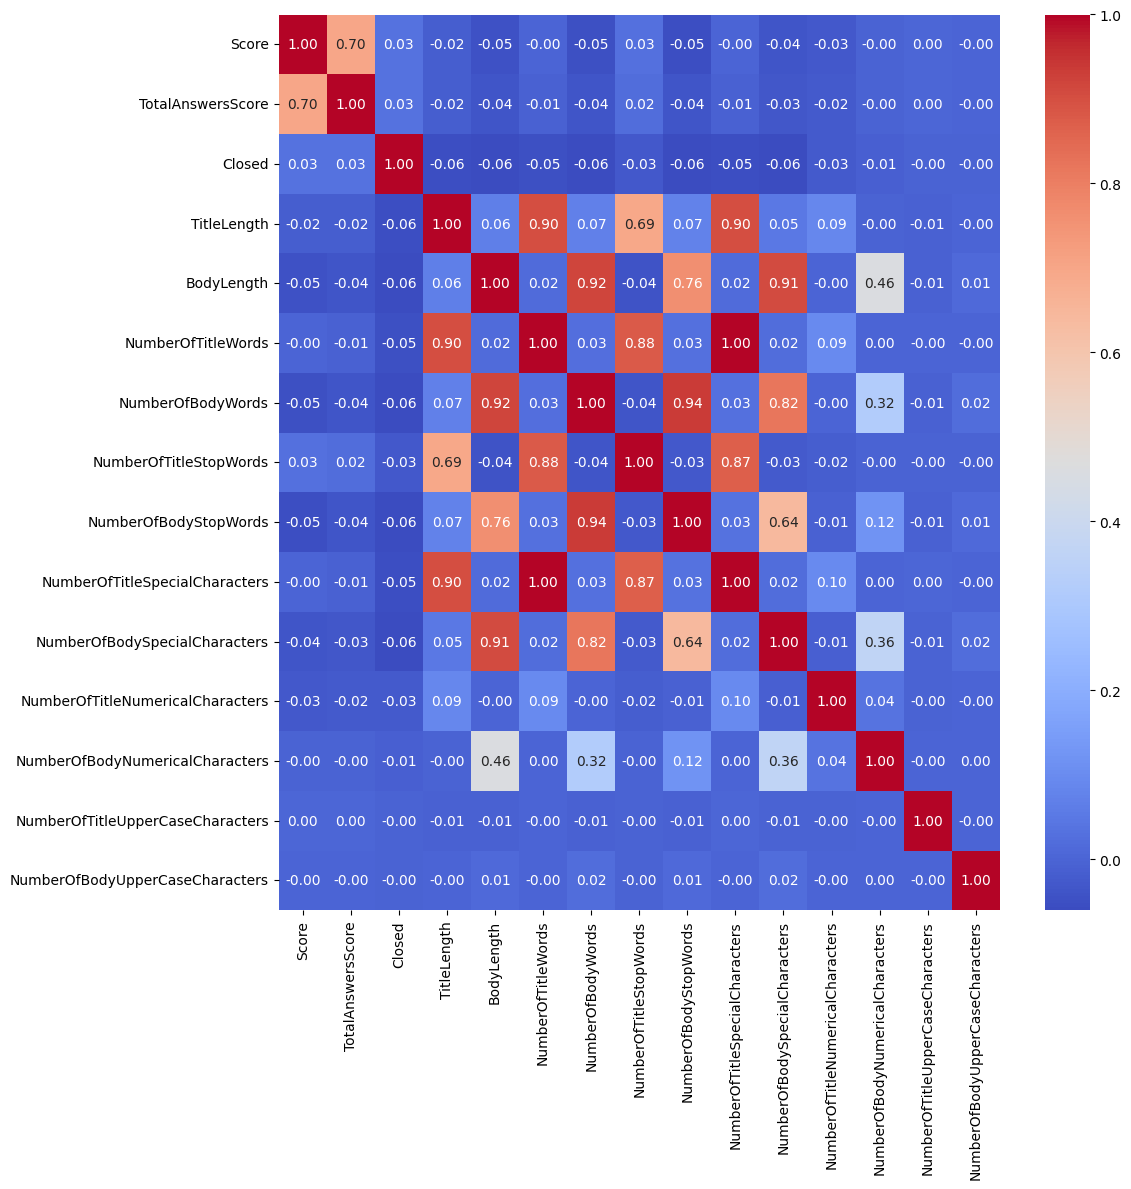

In [5]:
data_analysis_path = './data_analysis/'
processed_file_path = './Questions_with_TotalAnswersScore.csv'
analyzed_file_path = './Analyzed_Questions.csv'

analysis = DataAnalysis(processed_file_path, data_analysis_path)
analysis.calculate_lengths()
analysis.calculate_word_counts()
analysis.calculate_characteristics()
analysis.plot_correlation_matrix()
analysis.calculate_tfidf()
analysis.save_analyzed_data(analyzed_file_path)

del analysis

## Plots before standarization

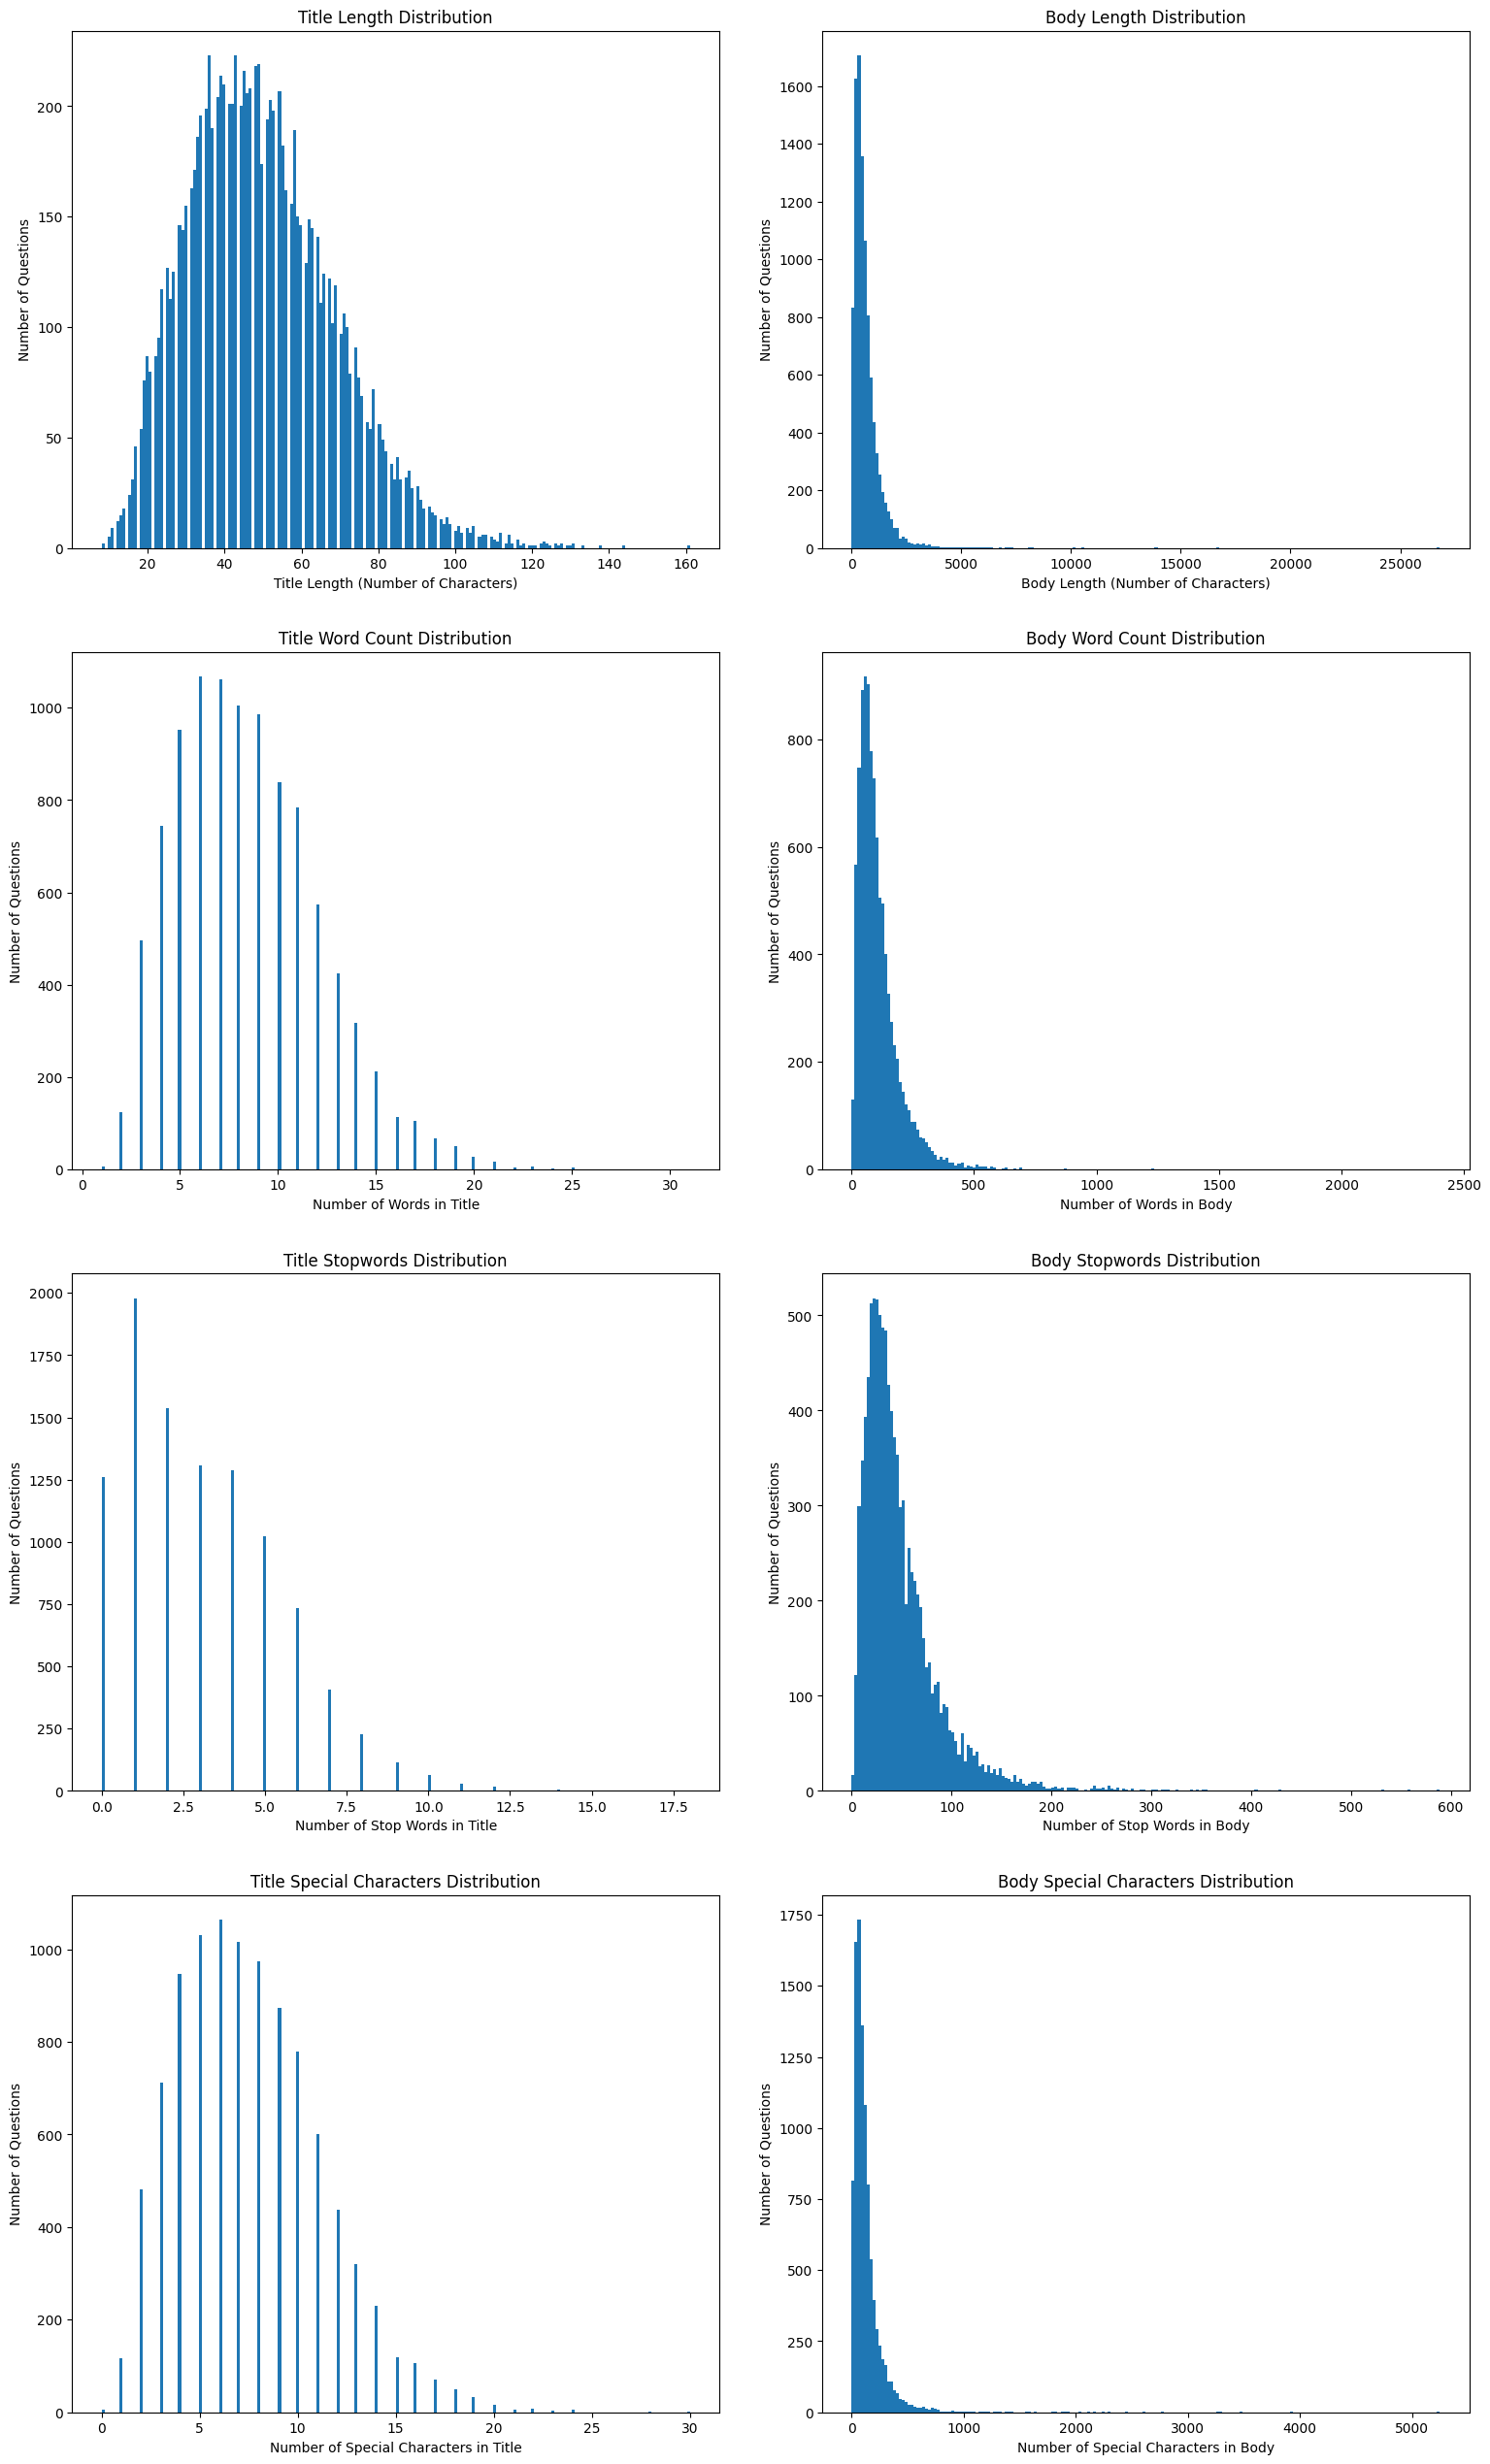

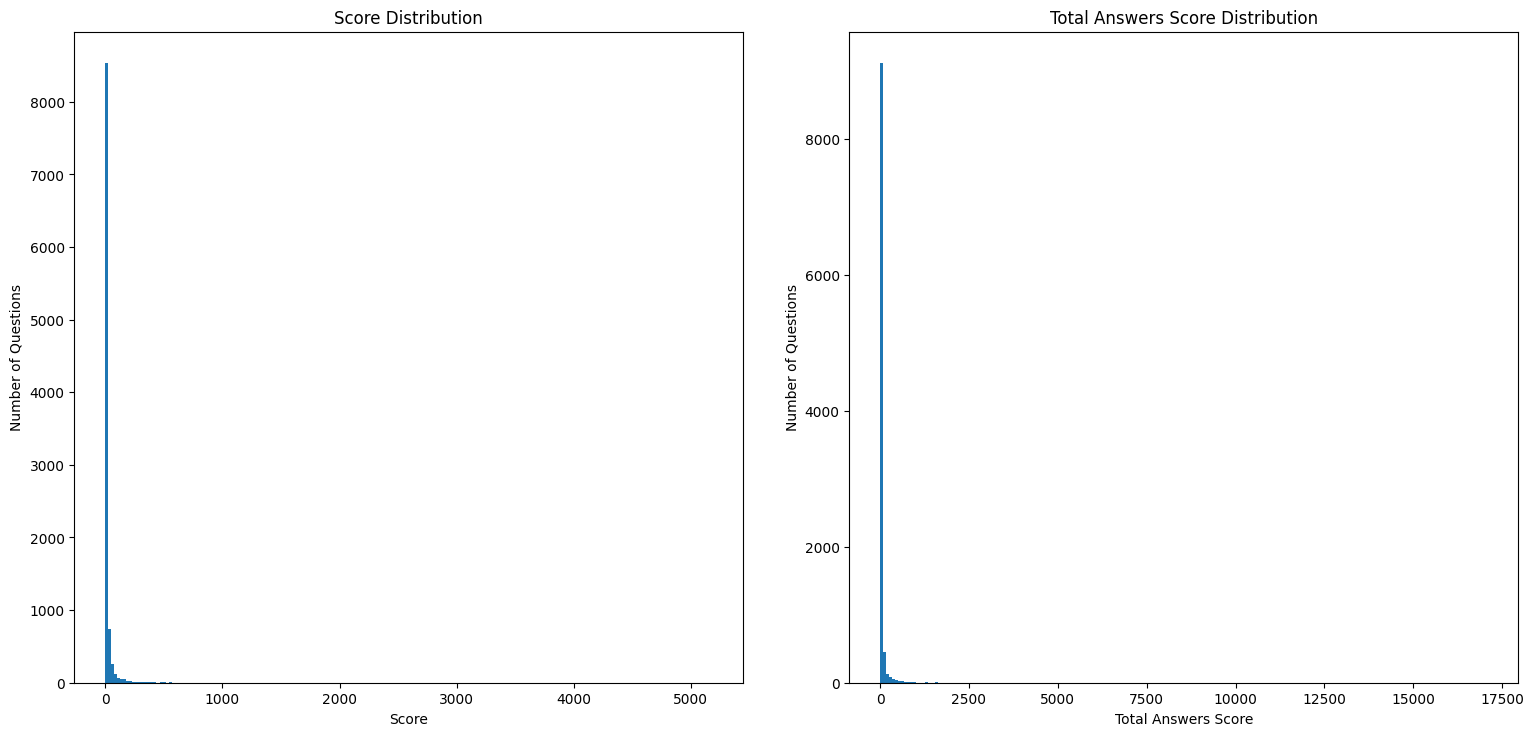

In [6]:
plot_manager = PlotManager(analyzed_file_path)
plot_manager.plot_distributions()
del plot_manager

## Data Standarization

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from numpy import log1p

class DataStandardization:
    def __init__(self, csv_file_path):
        self.csv_file_path = csv_file_path
        self.df = self.load_csv()
        self.scaler = StandardScaler()

    def load_csv(self):
        try:
            return pd.read_csv(self.csv_file_path)
        except FileNotFoundError:
            print(f"File not found: {self.csv_file_path}")
            return None

    def remove_outliers_with_percentile(self, column_name, lower_percentile=0.05, upper_percentile=0.95):
        if column_name not in self.df.columns:
            print(f"Column '{column_name}' not found in DataFrame.")
            return
        
        lower_bound = self.df[column_name].quantile(lower_percentile)
        upper_bound = self.df[column_name].quantile(upper_percentile)
        self.df = self.df[(self.df[column_name] >= lower_bound) & (self.df[column_name] <= upper_bound)]

    def save_to_csv(self, output_file_path):
        self.df.to_csv(output_file_path, index=False)

    def replace_extremes(self, column_name, lower_percentile=0.005, upper_percentile=0.995):
        if column_name not in self.df.columns:
            print(f"Column '{column_name}' not found in DataFrame.")
            return
        
        winsor_limits = (lower_percentile, 1 - upper_percentile)
        self.df[column_name] = winsorize(self.df[column_name], limits=winsor_limits)

In [8]:
standardization = DataStandardization(analyzed_file_path)
standarizaded_file = './Standarizaded_Questions.csv'
columns_to_remove_by_percentile = ['Score', 'TotalAnswersScore', 'BodyLength', 'NumberOfBodyUpperCaseCharacters']
columns_to_remove_by_minor_percentile = ['NumberOfBodyStopWords', 'NumberOfBodySpecialCharacters']
columns_to_winsorize = ['BodyLength', 'NumberOfBodyStopWords', 'NumberOfTitleWords', 'NumberOfBodyWords',
                        'NumberOfTitleStopWords', 'NumberOfTitleSpecialCharacters', 'NumberOfBodySpecialCharacters',
                        'NumberOfTitleNumericalCharacters', 'NumberOfBodyNumericalCharacters',
                        'NumberOfTitleUpperCaseCharacters', 'NumberOfBodyUpperCaseCharacters'];

for column in columns_to_remove_by_percentile:
    standardization.remove_outliers_with_percentile(column)

for column in columns_to_remove_by_minor_percentile:
    standardization.remove_outliers_with_percentile(column, 0.03, 0.97)
    
for column in columns_to_winsorize:
    standardization.replace_extremes(column)

standardization.save_to_csv(standarizaded_file)
    
del standardization


### Plots after standarization

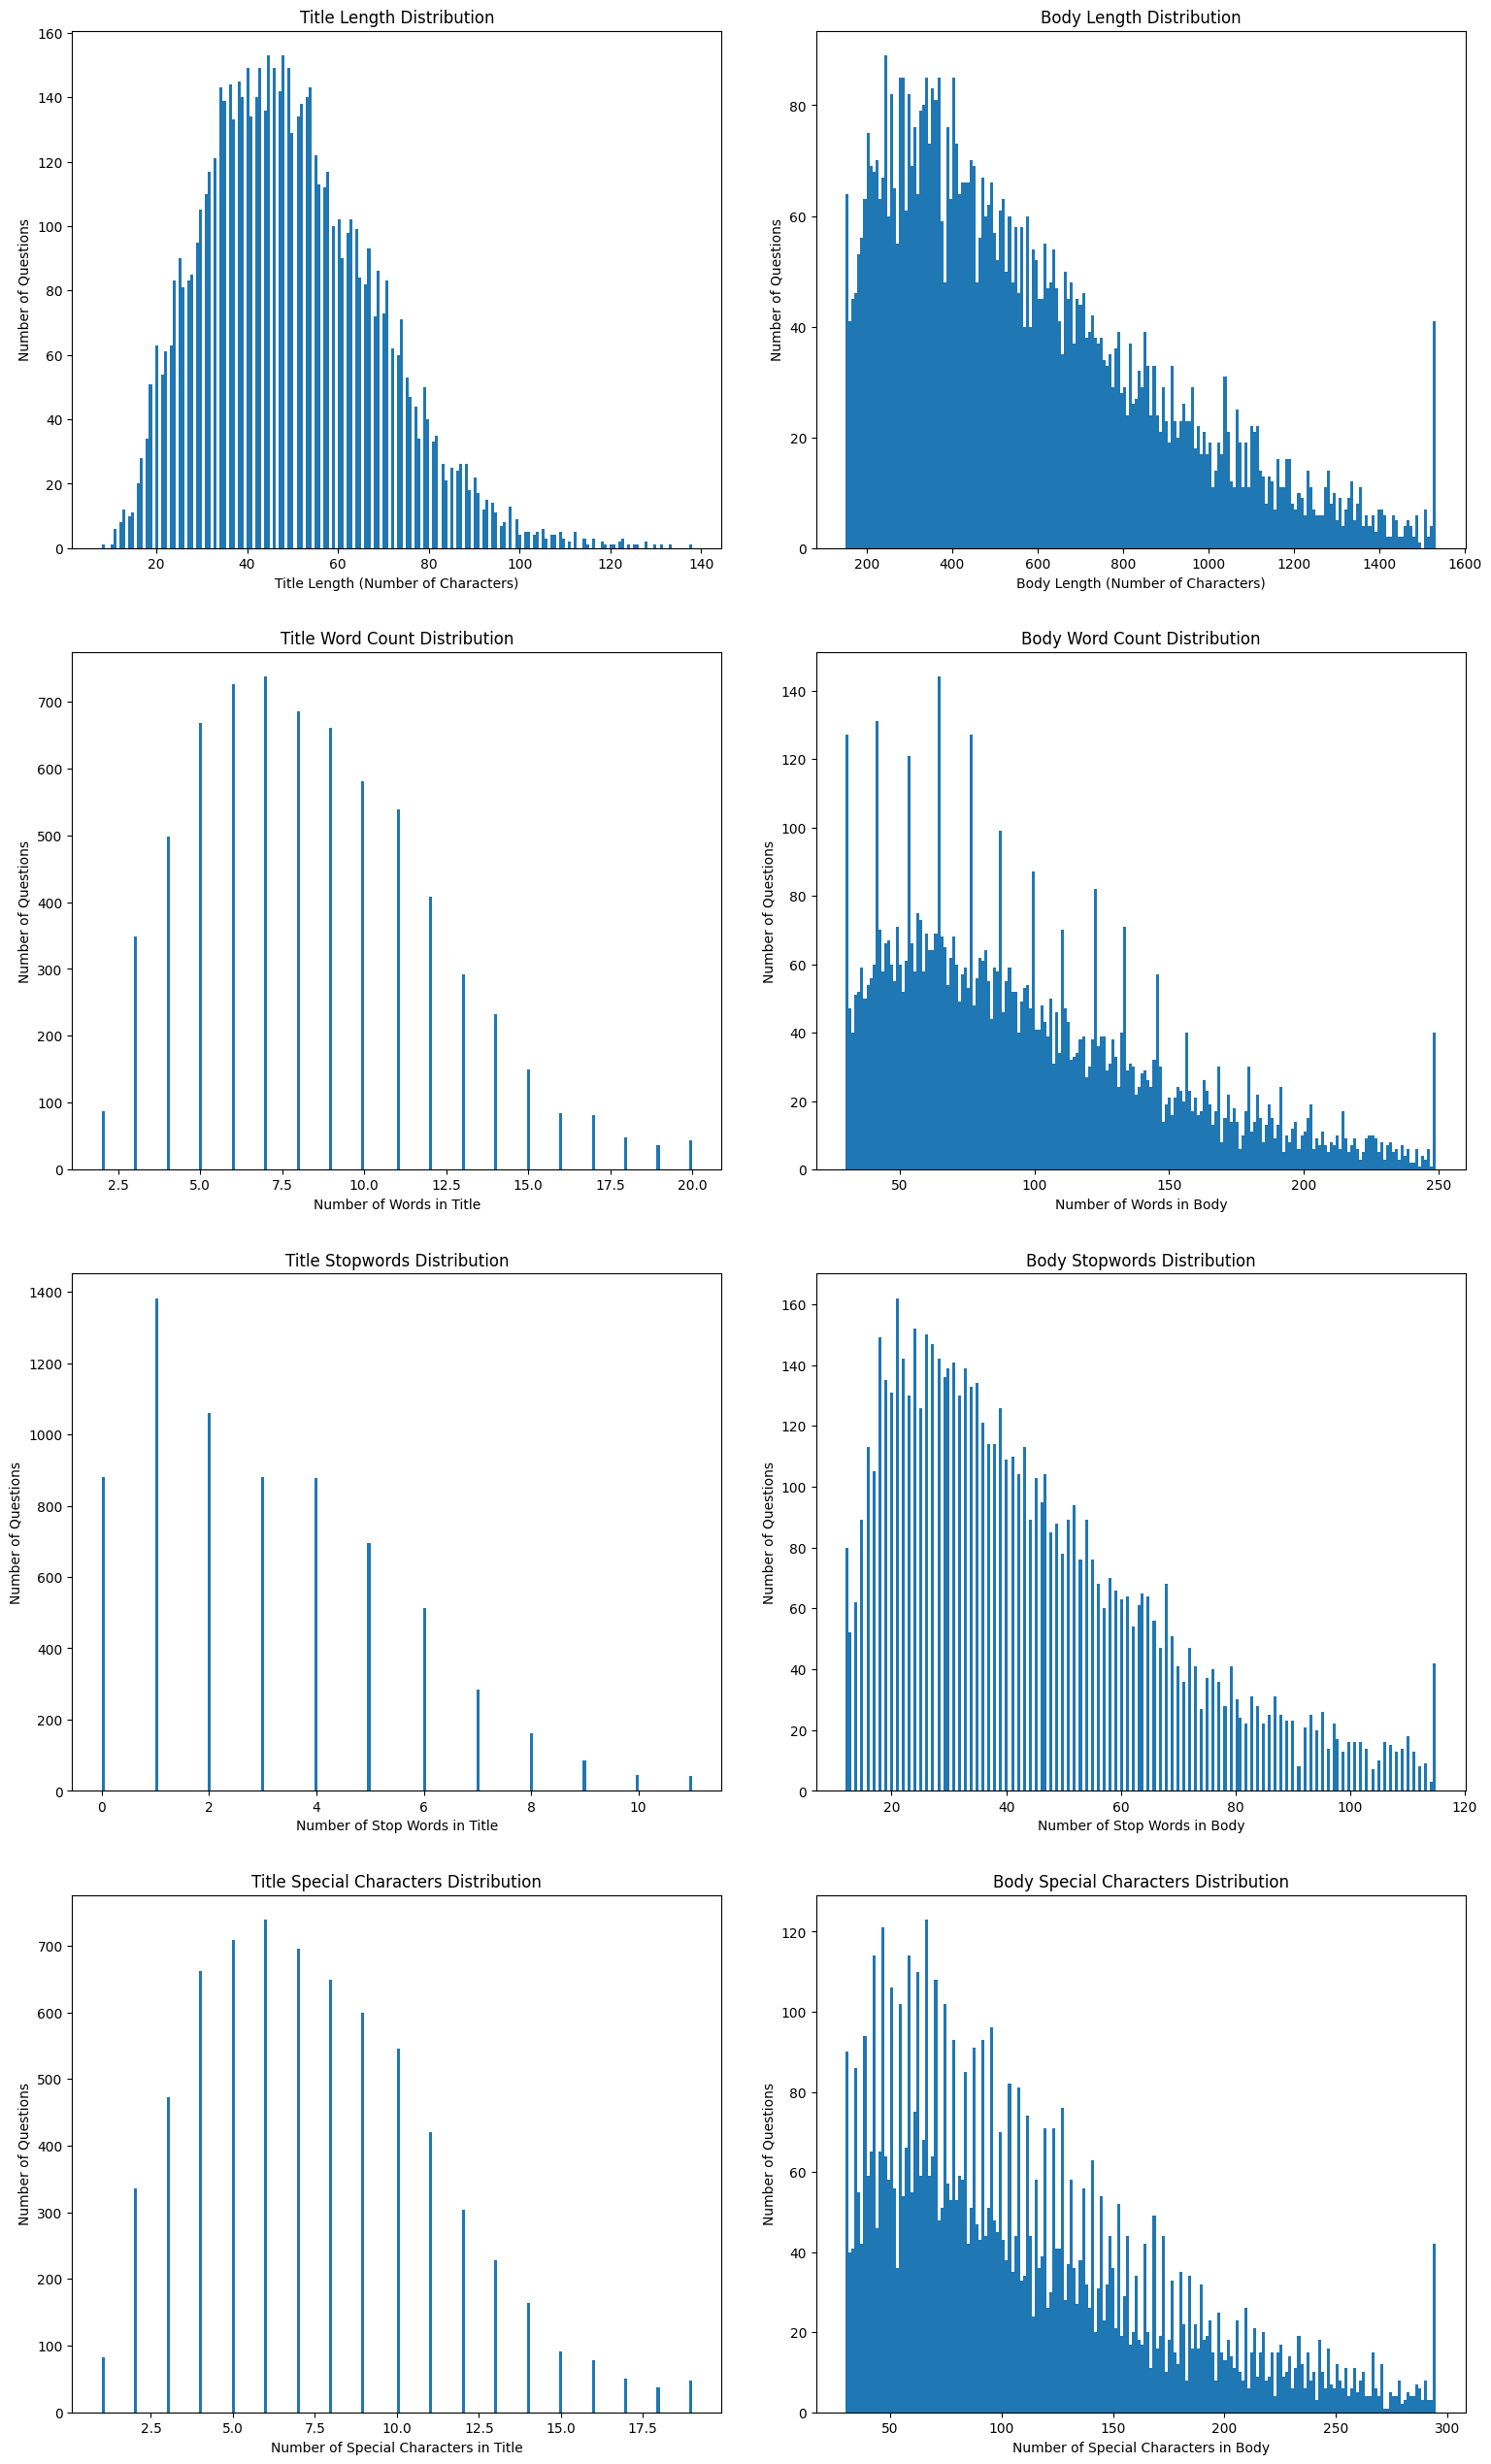

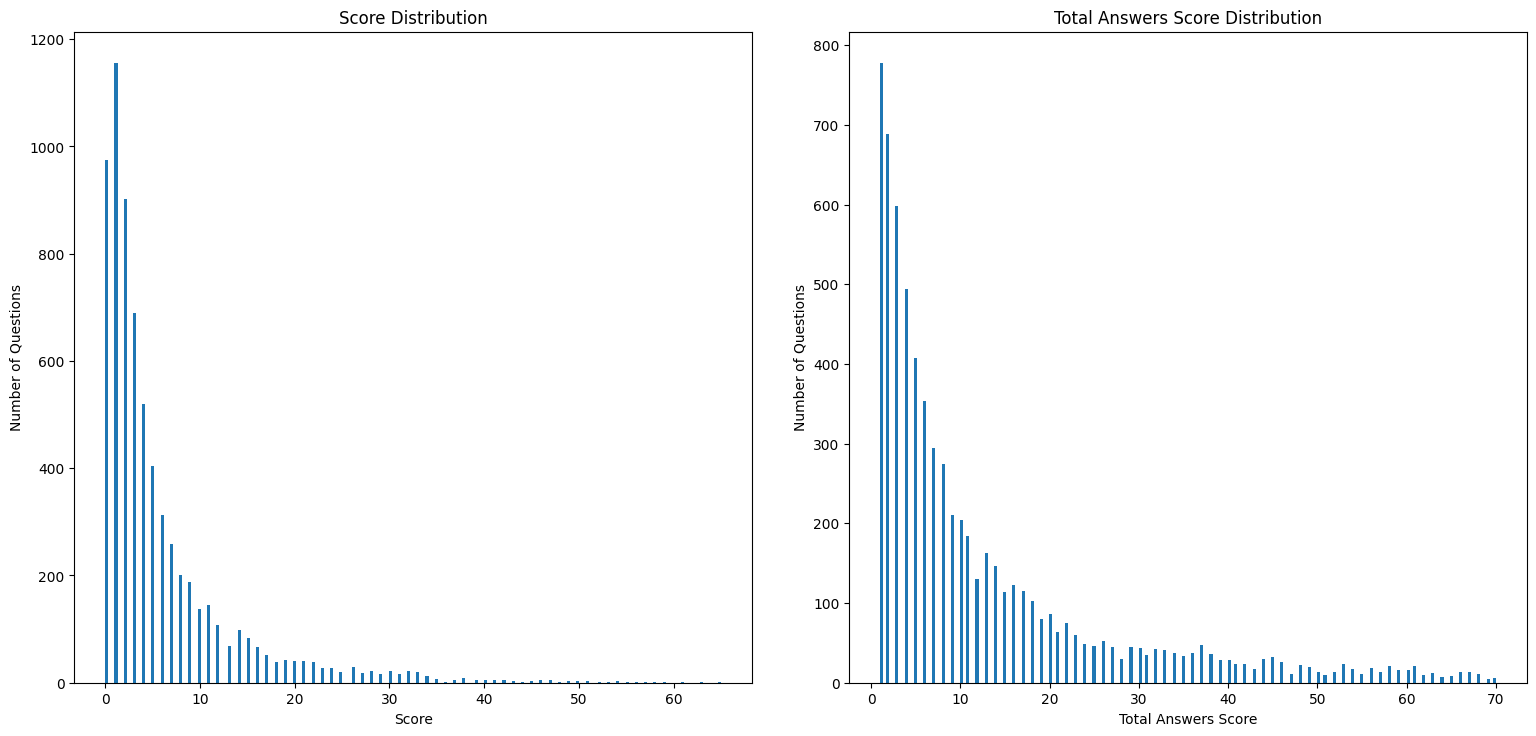

In [9]:
plot_manager = PlotManager(standarizaded_file)
plot_manager.plot_distributions()
del plot_manager

In [10]:

modified_qustions_df = pd.read_csv(standarizaded_file, encoding="ISO-8859-1")

In [11]:
modified_qustions_df.head()

,Score,Title,Body,TotalAnswersScore,Closed,TitleLength,BodyLength,NumberOfTitleWords,NumberOfBodyWords,NumberOfTitleStopWords,...,NumberOfTitleSpecialCharacters,NumberOfBodySpecialCharacters,NumberOfTitleNumericalCharacters,NumberOfBodyNumericalCharacters,NumberOfTitleUpperCaseCharacters,NumberOfBodyUpperCaseCharacters,ProcessedTitle,ProcessedBody,TitleTfidf,BodyTfidf
0,21,aspnet site maps,has anyone got experience creating sqlbased as...,9.0,False,16,337,3,56,0,...,2,56,0,0,0,0,aspnet site map,anyone got experience creating sqlbased aspnet...,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.]
1,53,function for creating color wheels,this is something ive pseudosolved many times ...,54.0,False,34,220,5,41,1,...,4,41,0,0,0,0,function creating color wheel,something ive many time never quite found solu...,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.]
2,49,adding scripting functionality to net applicat...,i have a little game written in c it uses a da...,63.0,False,50,989,6,172,1,...,5,176,0,7,0,0,adding scripting functionality net application,little game written c us database backend card...,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.]
3,29,should i use nested classes in this case,i am working on a collection of classes used f...,39.0,False,40,911,8,167,4,...,7,168,0,0,0,0,use nested class case,working collection class used video playback r...,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.]
4,13,homegrown consumption of web services,ive been writing a few web services for a net ...,8.0,True,37,294,5,52,1,...,4,53,0,0,0,0,homegrown consumption web service,ive writing web service net app im ready consu...,[0. 0. 0. ... 0. 0. 0.],[0. 0. 0. ... 0. 0. 0.]


In [12]:
from sklearn.model_selection import train_test_split

y = modified_qustions_df['Score']
x = modified_qustions_df.drop('Score', axis=1)


X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



### Training AI

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

regressor = RandomForestRegressor(n_estimators=100, random_state=42)

plot_learning_curve(regressor, "Learning Curve (Random Forest)", x, y, cv=5, n_jobs=4)
plt.show()


# AI Training (New)

### Prepering data for training

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# load processed data
processd_file_path = './Questions_with_TotalAnswersScore.csv'
processed_df = pd.read_csv(processd_file_path, encoding = "ISO-8859-1")

# split data into training and testing sets (95% for training and 5% for testing)
training_df, test_df = train_test_split(processed_df, test_size=0.05, random_state=2137420)
print('Training data size: {}'.format(len(training_df)))
print('Testing data size: {}'.format(len(test_df)))

# create training data directory
training_data_directory = './training_data/'
if not os.path.exists(training_data_directory):
    os.makedirs(training_data_directory)

# save training data to CSV files
training_data_file = os.path.join(training_data_directory, 'training_data.csv')
training_df.to_csv(training_data_file, index=False)

# save testing data to CSV files
test_data_file = os.path.join(training_data_directory, 'test_data.csv')
test_df.to_csv(test_data_file, index=False)

# reset kernel after running this cell to free up memory

In [ ]:
# run this cell if you have already downloaded the dataset and processed it and split it into training and testing sets
import os

training_data_directory = './training_data/'
if not os.path.exists(training_data_directory):
    print('Training data directory does not exist')

training_data_file = os.path.join(training_data_directory, 'training_data.csv')
if not os.path.exists(training_data_file):
    print('Training data file does not exist')

test_data_file = os.path.join(training_data_directory, 'test_data.csv')
if not os.path.exists(test_data_file):
    print('Test data file does not exist')

### Data processing

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

def calc_data_statistic(data): 
    # calculating lenght of title and body
    data['TitleLength'] = data['Title'].str.len()
    data['BodyLength'] = data['Body'].str.len()

    # calculating number of words in Title and Body
    data['NumberOfTitleWords'] = data['Title'].apply(lambda x: len(str(x).split(" ")))
    data['NumberOfBodyWords'] = data['Body'].apply(lambda x: len(str(x).split(" ")))

    # calculating the number of stop words in Title and Body
    data['NumberOfTitleStopWords'] = data['Title'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))
    data['NumberOfBodyStopWords'] = data['Body'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))

    # calculating the number special characters in Title and Body
    list_of_special_characters = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '-', '+', '=', '{', '}', '[', ']', '|', '\\', ':', ';', '"', "'", '<', '>', ',', '.', '?', '/', '~', '`']
    data['NumberOfTitleSpecialCharacters'] = data['Title'].apply(lambda x: len([char for char in str(x) if char in list_of_special_characters]))
    data['NumberOfBodySpecialCharacters'] = data['Body'].apply(lambda x: len([char for char in str(x) if char in list_of_special_characters]))

    # calculating the number of numerical characters in Title and Body
    data['NumberOfTitleNumericalCharacters'] = data['Title'].apply(lambda x: len([char for char in str(x) if char.isnumeric()]))
    data['NumberOfBodyNumericalCharacters'] = data['Body'].apply(lambda x: len([char for char in str(x) if char.isnumeric()]))

    # calculating the number of uppercase characters in Title and Body
    data['NumberOfTitleUpperCaseCharacters'] = data['Title'].apply(lambda x: len([char for char in str(x) if char.isupper()]))
    data['NumberOfBodyUpperCaseCharacters'] = data['Body'].apply(lambda x: len([char for char in str(x) if char.isupper()]))

    return data

In [ ]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
dd
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.wordsdd('english'))
lemmatizer = WordNetLemmatizer()

max_features_count = 1000
title_features_list = []
body_features_list = []

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

    

In [ ]:
def normalize_data_and_convert_to_tfidf_and_save_features_list(data):
    global title_features_list
    global body_features_list

    tfidf_title = TfidfVectorizer(max_features=max_features_count)
    title_tfidf = tfidf_title.fit_transform(data['Title'].astype(str).apply(normalize_text))
    title_tfidf_df = pd.DataFrame(title_tfidf.toarray(), columns=tfidf_title.get_feature_names_out())

    tfidf_body = TfidfVectorizer(max_features=max_features_count)
    body_tfidf = tfidf_body.fit_transform(data['Body'].astype(str).apply(normalize_text))
    body_tfidf_df = pd.DataFrame(body_tfidf.toarray(), columns=tfidf_body.get_feature_names_out())

    title_features_list = title_tfidf_df.columns.tolist()
    body_features_list = body_tfidf_df.columns.tolist()

    combined_data = pd.concat([data.drop(['Title', 'Body', 'Id'], axis=1), title_tfidf_df, body_tfidf_df], axis=1)
    return combined_data

In [ ]:
def normalize_data_and_convert_to_tfidf(data):
    global title_features_list
    global body_features_list

    if len(title_features_list) == 0 or len(body_features_list) == 0:
        print('Title and Body features list are empty')
        exit()
    
    tfidf_title = TfidfVectorizer(max_features=max_features_count)
    title_tfidf = tfidf_title.fit_transform(data['Title'].astype(str).apply(normalize_text))
    title_tfidf_df = pd.DataFrame(title_tfidf.toarray(), columns=title_features_list)

    tfidf_body = TfidfVectorizer(max_features=max_features_count)
    body_tfidf = tfidf_body.fit_transform(data['Body'].astype(str).apply(normalize_text))
    body_tfidf_df = pd.DataFrame(body_tfidf.toarray(), columns=body_features_list)

    combined_data = pd.concat([data.drop(['Title', 'Body', 'Id'], axis=1), title_tfidf_df, body_tfidf_df], axis=1)
    return combined_data

In [ ]:
def prepare_data_for_training(data_set, test_data = False):
    data_set = calc_data_statistic(data_set)
    
    if test_data == True:
        data_set = normalize_data_and_convert_to_tfidf_and_save_features_list(data_set) # save features list for later use
    else:
        data_set = normalize_data_and_convert_to_tfidf(data_set)

    return data_set

### Main training function

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def training_iteration(trained_model, x_train, y_train, x_test, y_test):
    # Training function
    trained_model.fit(x_train, y_train)

    # Predicting the test set results
    predictions_result = trained_model.predict(x_test)
    predictions_result = predictions_result.astype(int)
    y_test = y_test.astype(int)
    
    # Calculating the accuracy, precision, recall and f1 score
    accuracy = accuracy_score(y_test, predictions_result)
    precision = precision_score(y_test, predictions_result, average='macro', zero_division=1)
    recall = recall_score(y_test, predictions_result, average='macro', zero_division=1)
    fscore = f1_score(y_test, predictions_result, average='macro', zero_division=1)

    return trained_model, (accuracy, precision, recall, fscore)

### Saving model to file for backup and later use

In [ ]:
# Cleaning up models folder
import shutil
model_path = "./models/"
shutil.rmtree(model_path)

In [ ]:
import os
import joblib
from datetime import datetime

model_path = "./models/"
if not os.path.exists(model_path):
    os.makedirs(model_path)

def save_model(classifier, id):
    timestam_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = "model_{}_{}.joblib".format(id, timestam_str)
    model_target_path = os.path.join(model_path, model_name)

    joblib.dump(classifier, model_target_path)

### Function to monitor training time

In [ ]:
# function to calculate the time difference to show how long it took to train the model
from datetime import datetime

def get_time_diff(start_time):
    time_delta = (datetime.now() - start_time).total_seconds()
    hours, remainder = divmod(time_delta, 3600)
    minutes, seconds = divmod(remainder, 60)
    time_diff_str = "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds)
    return time_diff_str

### Model preparation

In [ ]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(random_state=420)

### Load test data

In [ ]:
import sys
import pandas as pd

sys.stdout.write("Loading test data... \n")

# Loading test data from CSV file
sys.stdout.write("\tLoading test data from CSV file... \n")
test_df = pd.read_csv(test_data_file, encoding = "ISO-8859-1")

# Preparing test data for training
sys.stdout.write("\tPreparing test data for training... \n")
processed_test_df = prepare_data_for_training(test_df, test_data=True)

# Splitting test data into x and y sets
sys.stdout.write("\tSplitting test data into x and y sets... \n")
x_test_data = processed_test_df.drop('Score', axis=1)
y_test_data = processed_test_df['Score']

sys.stdout.write("\nDone!\n")


In [ ]:
# print(processed_test_df.head())
# print(x_test_data.head())
# print(y_test_data.head())
processed_test_df.head()


### Training loop

In [ ]:
import sys
import pandas as pd
from datetime import datetime

sys.stdout.write("Training started... \n")
sys.stdout.write("-" * 80 + "\n")

# Configure training parameters
data_batch_is_not_empty = True
bach_size = 5000 # for test 500, for training optimal around 10000 (limit is your RAM)
start_offset = 0 # use if strat

# list to store training results for each batch
training_results_list = []

# save start time
start_time = datetime.now()

# read headers from CSV file
headers_list = pd.read_csv(training_data_file, encoding = "ISO-8859-1", nrows=0, header=0)

# pritnt training parameters to console
sys.stdout.write("training time; start offset; \t accuracy; precision; recall; f1 score\n")

# training loop
while data_batch_is_not_empty:
    # read data batch
    data_batch = pd.read_csv(training_data_file, encoding = "ISO-8859-1", skiprows=start_offset+1, nrows=bach_size, header=None, names=list(headers_list.columns))

    # check if data batch is empty
    if data_batch.empty:
        data_batch_is_not_empty = False
        break

    # while loop emergency break
    if start_offset > 1500000: # 1.5M row, data set have 1.2M rows
        break
    if (datetime.now() - start_time).total_seconds() > (60*60) * 12: # 12 hours
        break

    # while loop break for testing
    if start_offset > 250000: # 250k rows
        break
    
    # prepare data for training
    processed_data_batch = prepare_data_for_training(data_batch)
    x_data_batch = processed_data_batch.drop('Score', axis=1)
    y_data_batch = processed_data_batch['Score']

    # train model
    model, training_result = training_iteration(model, x_data_batch, y_data_batch, x_test_data, y_test_data)
    training_results_list.append(training_result)

    # print training results
    sys.stdout.write("{: <12} \t {: <9} \t\t {:.3f} \t {:.3f} \t {:.3f} \t {:.3f} \n".format(get_time_diff(start_time), start_offset, *training_result))

    # save model
    if start_offset/bach_size % 5 == 0 and start_offset != 0:
        sys.stdout.write("Saving model... \n")
        save_model(model, int(start_offset/bach_size))
    
    # update start offset
    start_offset += bach_size


sys.stdout.write("\nSaving model... \n")
save_model(model, 'final')

sys.stdout.write("-" * 80 + "\n")
sys.stdout.write("Training ended!\n")
sys.stdout.write("Total training time: {}\n".format(get_time_diff(start_time)))
sys.stdout.write("-" * 80 + "\n")



### Show results

In [ ]:
import random
random.seed(420)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

for i in range(0, 25):
    index = random.randint(0, len(x_test_data))
    predicted_score = model.predict([x_test_data.iloc[index]])[0]
    print("index: {: <5} \t predicted score: {: <5} \t actual score: {: <5}".format(index, predicted_score, y_test_data.iloc[index]))


### Plot training results

In [ ]:
import os
import matplotlib.pyplot as plt

# create data analysis directory
data_analysis_path = './data_analysis/'
if not os.path.exists(data_analysis_path):
    os.makedirs(data_analysis_path)

# converting the performance list to a dataframe
training_result_df = pd.DataFrame(training_results_list, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# plotting the performance
plt.figure(figsize=(16, 6))

plt.plot(training_result_df['Accuracy'], label='Accuracy')
plt.plot(training_result_df['Precision'], label='Precision')
plt.plot(training_result_df['Recall'], label='Recall')
plt.plot(training_result_df['F1 Score'], label='F1 Score')

plt.xlabel('Training Iteration')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.grid()

plt.xlim(0, len(training_result_df))
plt.ylim(0, 1)

plt.savefig(data_analysis_path + 'training_iteration_accuracy.png', dpi=300)
plt.show()